<a href="https://colab.research.google.com/github/kikiymini/7506R-1C2024-GRUPO02/blob/main/7506R_TP1_GRUPO02_ENTREGA_N2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>Organizaci&oacute;n de Datos</center>

#### <center>C&aacute;tedra Ing. Rodriguez, Juan Manuel </center>

## <center>Trabajo Práctico 1: Propiedades en venta</center>

### <center> Grupo 2</center>

## Integrantes:

*   Aramayo Carolina
*   Utrera Maximo Damian
*   Villalba Ana Daniela
*   Fiorilo Roy


<font color='#fa5050'>Importante: para correr este notebook es pre-requisito haber corrido el notebook numero 1, ya que de lo contrario no se tienen los datasets de train y test.</font>

# Importación de librerias

(Importante: leer comentarios)

In [245]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
import folium
from yellowbrick.cluster import SilhouetteVisualizer
# yellowbrick depends on distutils, which is deprecated in Python 3.10 and removed in Python 3.12. (colab uses python 3.10.12 so it works)
# https://docs.python.org/3.10/library/distutils.html
from folium.plugins import MarkerCluster

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score

import geopandas as gpd

import warnings
warnings.filterwarnings("ignore")

# consts
KMEANS_SEED = 42

# Lectura de archivo

### Desde google drive

In [246]:
from google.colab import drive
drive.mount('/content/drive')
drive_path = "/content/drive/MyDrive/7506R-1C2024-GRUPO02"

train_file = drive_path + '/Dataset/ds_train.csv'
test_file = drive_path + '/Dataset/ds_test.csv'
barrios_file = drive_path + '/Dataset/barrios.csv'

ds_barrios = pd.read_csv(barrios_file, header=0,sep=';')
ds_train = pd.read_csv(train_file)
ds_test = pd.read_csv(test_file)
using_drive = True

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Desde maquina local

In [247]:
# Si se esta trabajando en local, descomentar esta celta y comentar la de arriba
# train_file = './dataset/ds_train.csv'
# test_file = './dataset/ds_test.csv'

# ds_train = pd.read_csv(train_file)
# ds_test = pd.read_csv(test_file)
# using_drive = False

# Agrupamiento

Analizaremos la tendencia al agrupamiento del dataset y la cantidad optima de grupos.

In [248]:
# Copias para trabajar
ds_cluster_train = ds_train.copy()
ds_cluster_test = ds_test.copy()

In [249]:
# Borro columnas que ya no seran usadas
to_remove = ['z_property_bedrooms', 'zm_property_bedrooms', 'place_encoded', 'type_encoded']
ds_cluster_train.drop(columns=to_remove, inplace=True)

## Tendencia al clustering
Analizar la tendencia al clustering del dataset.

In [250]:
ds_cluster_train.head()

id  start_date    end_date  created_on    latitud  \
0  sH/yN2YdtUSSJepTsIXyjQ==  2021-03-06  2021-03-18  2021-03-06 -34.621390   
1  8vhkDo5KTd+Wwz3QYRR7wg==  2021-05-13  2021-05-19  2021-05-13 -34.563005   
2  hnDEA6QbHN6K/57Hkhlrhg==  2021-10-14  2022-02-09  2021-10-14 -34.612349   
3  FMJCKPGRvEjbz0NBCaZ3Gw==  2021-10-01  2021-10-07  2021-10-01 -34.620806   
4  GgQjrtJSz1N4jQ8aSuNudA==  2021-05-28  2021-06-05  2021-05-28 -34.558229   

    longitud          place_l3 property_type  property_rooms  \
0 -58.506366      Monte Castro  Departamento               3   
1 -58.453674          Belgrano  Departamento               3   
2 -58.491906  Villa del Parque  Departamento               3   
3 -58.397336             Boedo            PH               3   
4 -58.446708          Belgrano  Departamento               3   

   property_bedrooms  property_surface_total  property_surface_covered  \
0                  2                    51.0                      44.0   
1                  2                    79.0                      66.0   
2                  2                   110.0                      80.0   
3                  2                    97.0                      67.0   
4                  2                    89.0                      89.0   

   property_price  
0        112000.0  
1        299900.0  
2        249000.0  
3        135000.0  
4        300000.0

Para agrupar, podemos eliminar la columna 'id', ya que generalmente solo sirve como un identificador único para cada fila y no es una característica relevante para el clustering. Similarmente, podemos descartar cualquier información relacionada con fechas, ya que no es necesaria para nuestro análisis de clustering.

In [251]:
columnas_a_eliminar = ['id','start_date','end_date','created_on']
ds_cluster_train.drop(columns = columnas_a_eliminar,inplace=True)
ds_cluster_test.drop(columns = columnas_a_eliminar,inplace=True)

In [252]:
ds_cluster_train.head()

latitud   longitud          place_l3 property_type  property_rooms  \
0 -34.621390 -58.506366      Monte Castro  Departamento               3   
1 -34.563005 -58.453674          Belgrano  Departamento               3   
2 -34.612349 -58.491906  Villa del Parque  Departamento               3   
3 -34.620806 -58.397336             Boedo            PH               3   
4 -34.558229 -58.446708          Belgrano  Departamento               3   

   property_bedrooms  property_surface_total  property_surface_covered  \
0                  2                    51.0                      44.0   
1                  2                    79.0                      66.0   
2                  2                   110.0                      80.0   
3                  2                    97.0                      67.0   
4                  2                    89.0                      89.0   

   property_price  
0        112000.0  
1        299900.0  
2        249000.0  
3        135000.0  
4        300000.0

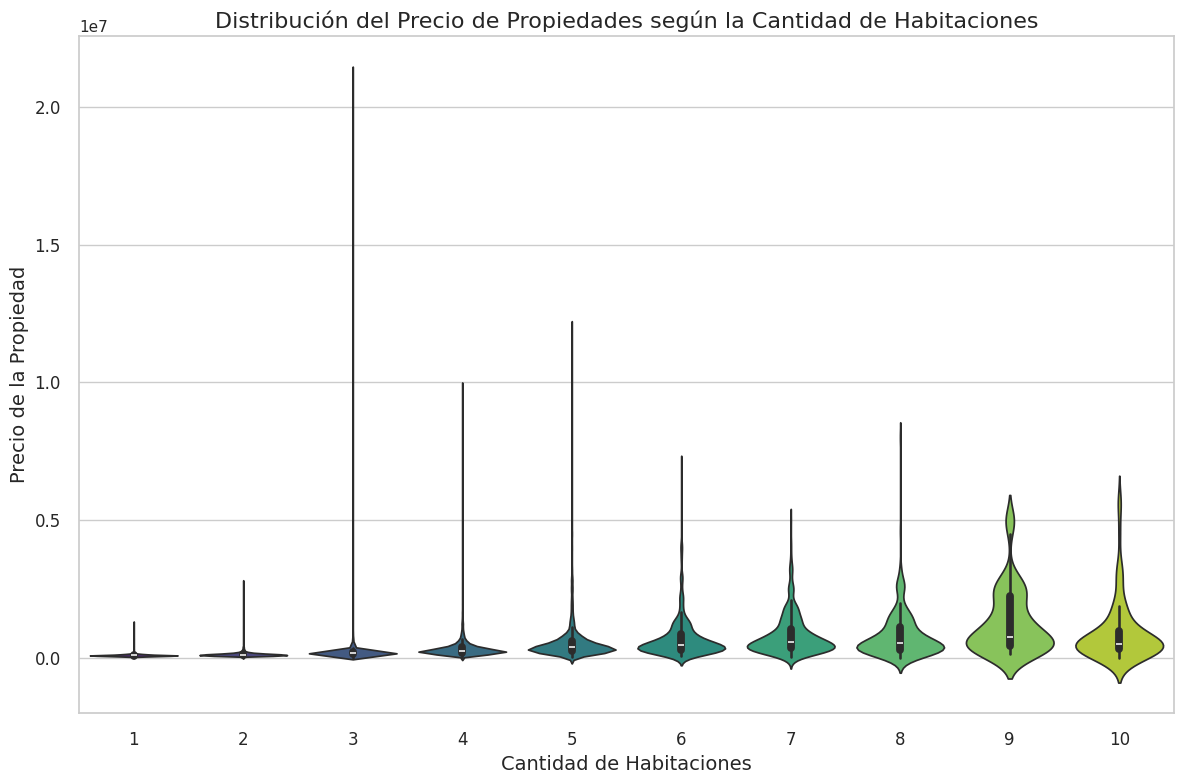

In [253]:
# Configurar el estilo de Seaborn
sns.set(style="whitegrid")

# Configurar el tamaño de la figura
plt.figure(figsize=(12, 8))

# Crear el Violin Plot con paleta de colores "viridis"
sns.violinplot(data=ds_cluster_train, x='property_rooms', y='property_price', palette='viridis')

# Añadir título y etiquetas con tamaño de fuente ajustado
plt.title('Distribución del Precio de Propiedades según la Cantidad de Habitaciones', fontsize=16)
plt.xlabel('Cantidad de Habitaciones', fontsize=14)
plt.ylabel('Precio de la Propiedad', fontsize=14)

# Ajustar tamaño de fuente de los ejes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Ajustar espaciado
plt.tight_layout()

# Mostrar el gráfico
plt.show()

Esta visualización muestra la distribución del precio de las propiedades en función de la cantidad de habitaciones. Para lograr esto, primero se redondea la variable property_rooms para facilitar la interpretación del gráfico. Luego, se utiliza un Violin Plot, que es una combinación de un box plot y un kernel density plot, para representar la distribución de los precios de las propiedades para cada cantidad de habitaciones.

Cada violín en el gráfico muestra la distribución de los precios para un número específico de habitaciones. La forma y el ancho de cada violín indican la densidad de los datos en esa región. Los box plots dentro de los violines muestran la mediana, los cuartiles y los valores atípicos de la distribución de los precios para cada cantidad de habitaciones.

El objetivo de esta visualización es proporcionar una comprensión visual de cómo varía el precio de las propiedades en función del número de habitaciones, lo que puede ayudar en la identificación de tendencias o patrones en el mercado inmobiliario.

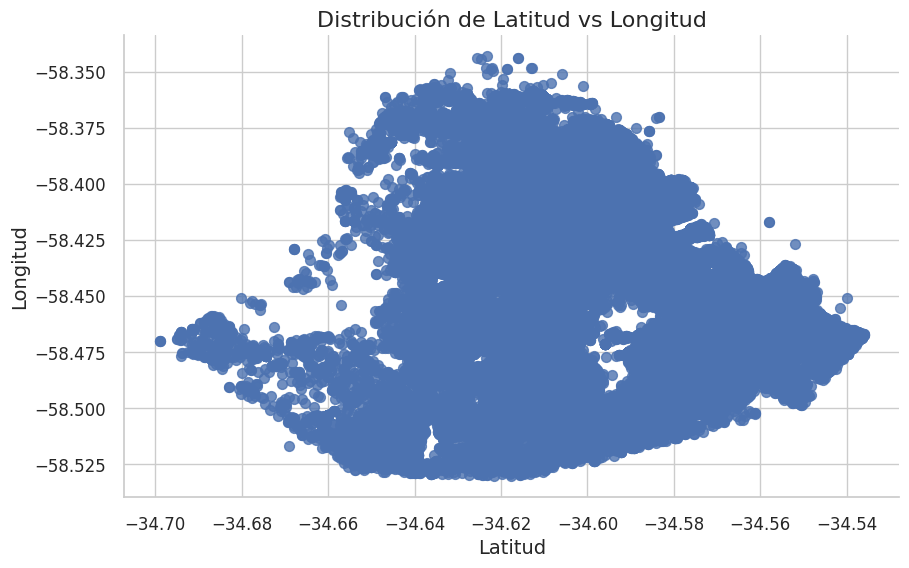

In [254]:
# @title latitud vs longitud

# Configuración de la figura y los ejes
plt.figure(figsize=(10, 6))

# Creación del gráfico de dispersión
plt.scatter(ds_cluster_train['latitud'], ds_cluster_train['longitud'], s=50, alpha=0.8)

# Ajustes del título y etiquetas
plt.title("Distribución de Latitud vs Longitud", fontsize=16)
plt.xlabel("Latitud", fontsize=14)
plt.ylabel("Longitud", fontsize=14)

# Ocultar los ejes superior y derecho
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Ajustar tamaño de fuente de los ejes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [255]:
ds_cluster_test.head()

latitud   longitud       place_l3 property_type  property_rooms  \
0 -34.587719 -58.418529        Palermo  Departamento             1.0   
1 -34.599837 -58.466978       Paternal          Casa             3.0   
2 -34.603665 -58.377891    San Nicolás  Departamento             1.0   
3 -34.615056 -58.379276      San Telmo  Departamento             1.0   
4 -34.564364 -58.494266  Villa Urquiza  Departamento             2.0   

   property_bedrooms  property_surface_total  property_surface_covered  \
0                1.0                    26.0                      20.0   
1                2.0                   100.0                      56.0   
2                1.0                    24.0                      24.0   
3                1.0                    36.0                      30.0   
4                1.0                    39.0                      37.0   

   property_price  
0         53000.0  
1        119000.0  
2         49900.0  
3         55000.0  
4         80900.0

Vamos a realizar una transformación de variables para trabajar con todos datos numéricos. En este caso, vamos a utilizar la regresión logística para la variable proterty_type

In [256]:
ds_cluster_train = pd.get_dummies(ds_cluster_train, columns=["property_type"])
ds_cluster_train.head()

latitud   longitud          place_l3  property_rooms  property_bedrooms  \
0 -34.621390 -58.506366      Monte Castro               3                  2   
1 -34.563005 -58.453674          Belgrano               3                  2   
2 -34.612349 -58.491906  Villa del Parque               3                  2   
3 -34.620806 -58.397336             Boedo               3                  2   
4 -34.558229 -58.446708          Belgrano               3                  2   

   property_surface_total  property_surface_covered  property_price  \
0                    51.0                      44.0        112000.0   
1                    79.0                      66.0        299900.0   
2                   110.0                      80.0        249000.0   
3                    97.0                      67.0        135000.0   
4                    89.0                      89.0        300000.0   

   property_type_Casa  property_type_Departamento  property_type_PH  
0               False                        True             False  
1               False                        True             False  
2               False                        True             False  
3               False                       False              True  
4               False                        True             False

In [257]:
ds_cluster_test = pd.get_dummies(ds_cluster_test, columns=["property_type"])
ds_cluster_test.head()

latitud   longitud       place_l3  property_rooms  property_bedrooms  \
0 -34.587719 -58.418529        Palermo             1.0                1.0   
1 -34.599837 -58.466978       Paternal             3.0                2.0   
2 -34.603665 -58.377891    San Nicolás             1.0                1.0   
3 -34.615056 -58.379276      San Telmo             1.0                1.0   
4 -34.564364 -58.494266  Villa Urquiza             2.0                1.0   

   property_surface_total  property_surface_covered  property_price  \
0                    26.0                      20.0         53000.0   
1                   100.0                      56.0        119000.0   
2                    24.0                      24.0         49900.0   
3                    36.0                      30.0         55000.0   
4                    39.0                      37.0         80900.0   

   property_type_Casa  property_type_Departamento  property_type_PH  
0               False                        True             False  
1                True                       False             False  
2               False                        True             False  
3               False                        True             False  
4               False                        True             False

In [258]:
# Mapear barrios a una representacion numerica
place_l3 = ds_cluster_train['place_l3'].unique()
place_l3_dict = dict(zip(place_l3, range(len(place_l3))))
place_l3_inv_dict = dict(zip(range(len(place_l3)), place_l3))
ds_cluster_train['place_l3'] = ds_cluster_train['place_l3'].map(place_l3_dict)
ds_cluster_train.head()

latitud   longitud  place_l3  property_rooms  property_bedrooms  \
0 -34.621390 -58.506366         0               3                  2   
1 -34.563005 -58.453674         1               3                  2   
2 -34.612349 -58.491906         2               3                  2   
3 -34.620806 -58.397336         3               3                  2   
4 -34.558229 -58.446708         1               3                  2   

   property_surface_total  property_surface_covered  property_price  \
0                    51.0                      44.0        112000.0   
1                    79.0                      66.0        299900.0   
2                   110.0                      80.0        249000.0   
3                    97.0                      67.0        135000.0   
4                    89.0                      89.0        300000.0   

   property_type_Casa  property_type_Departamento  property_type_PH  
0               False                        True             False  
1               False                        True             False  
2               False                        True             False  
3               False                       False              True  
4               False                        True             False

Aplico máximos y minimos para normalizar el dataset. De esta manera los valores seleccionados estaran escalados entre 0 y 1 acordemente.

In [259]:
def aplicar_max_min(ds, columnas):
    scaler = MinMaxScaler()
    for columna in columnas:
        ds[[columna]] = scaler.fit_transform(ds[[columna]])

columnas_con_numeros = ['property_bedrooms','property_rooms','property_surface_total','property_surface_covered', 'property_price']

aplicar_max_min(ds_cluster_train,columnas_con_numeros)

In [260]:
ds_cluster_train.head()

latitud   longitud  place_l3  property_rooms  property_bedrooms  \
0 -34.621390 -58.506366         0        0.222222           0.166667   
1 -34.563005 -58.453674         1        0.222222           0.166667   
2 -34.612349 -58.491906         2        0.222222           0.166667   
3 -34.620806 -58.397336         3        0.222222           0.166667   
4 -34.558229 -58.446708         1        0.222222           0.166667   

   property_surface_total  property_surface_covered  property_price  \
0                  0.0204                  0.043180        0.005234   
1                  0.0316                  0.064769        0.014014   
2                  0.0440                  0.078508        0.011636   
3                  0.0388                  0.065751        0.006308   
4                  0.0356                  0.087341        0.014019   

   property_type_Casa  property_type_Departamento  property_type_PH  
0               False                        True             False  
1               False                        True             False  
2               False                        True             False  
3               False                       False              True  
4               False                        True             False

## Cantidad de grupos a formar

Para estimar la cantidad de grupos que se deberian formar vamos a utilizar la Regla del codo (Elbow Method).

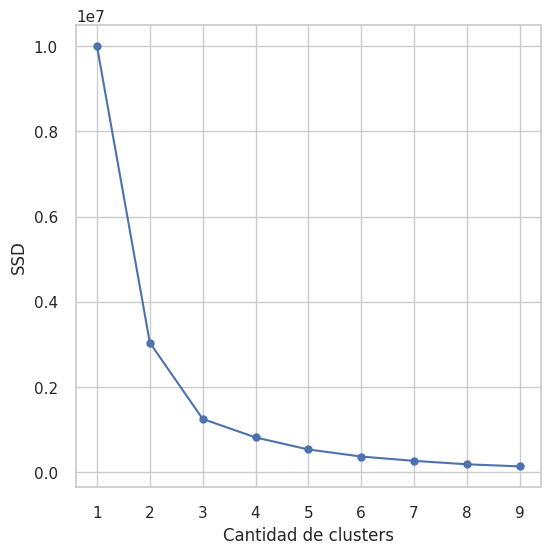

In [261]:
# Corro el algoritmo con K entre 2 y 10 y voy guardando el error para luego graficarlo.
ssd = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=KMEANS_SEED)
    km.fit(ds_cluster_train)
    ssd.append(km.inertia_)

# Grafico el SSD por K
plt.figure(figsize=(6, 6))
plt.plot(list_k, ssd, '-o')
plt.xlabel(r'Cantidad de clusters')
plt.ylabel('SSD')

# Si se quiere desactivar la notación científica en el eje y
# plt.ticklabel_format(style='plain', axis='y')

plt.show()

Al ver el gráfico no tenemos un codo pronunciadamente, pero sabemos que la cantidad optima de grupos esta entre 2 y 5. Entonces verificamos la cantidad de conjuntos a elegir con el método de Silhouette.

### Analisis de calidad de grupos con Silhouette
Evaluar la calidad de los grupos formados realizando un análisis de Silhouette.

Para esto se utilizaran entre 2 y 5 grupos siguiendo lo que observamos en el anterior grafico.

In [262]:
# Se define una lista de números de clusters a probar
list_k = list(range(2, 6))

# Se itera sobre cada número de clusters
for n_clusters in list_k:
    # Se inicializa el modelo de KMeans con el número de clusters actual
    clusterer = KMeans(n_clusters=n_clusters, random_state=KMEANS_SEED)

    # Se ajusta el modelo a los datos de entrenamiento y se realizan predicciones sobre los clusters
    preds = clusterer.fit_predict(ds_cluster_train)

    # Se calcula el coeficiente de Silhouette para evaluar la calidad de los clusters
    score = silhouette_score(ds_cluster_train, preds)

    # Se imprime el coeficiente de Silhouette para el número actual de clusters
    print("\n\nFor n_clusters =" + str(n_clusters) + " silhouette score is " + str(score))




For n_clusters =2 silhouette score is 0.665647182845321


For n_clusters =3 silhouette score is 0.6194346788249994


For n_clusters =4 silhouette score is 0.6080054449605583


For n_clusters =5 silhouette score is 0.5994963195630769


Un coeficiente de Silhouette cercano a 1 indica que los clusters están muy bien definidos, con una separación clara entre ellos. Por lo tanto, un coeficiente de Silhouette de 0.66 es decente y sugiere que la mejor cantidad de clusters es 2, ya que proporciona una buena separación entre los puntos de datos dentro de los clusters y una buena distancia entre los clusters. sin embargo estos clusters pueden no estar balanceados y no ser representativos del dataset, por esa razon en la siguiente parte analizaremos la distribucion de esos grupos.

### Analisis de distribucion de los grupos

Ahora veremos si estos grupos obtenidos estan balanceados.

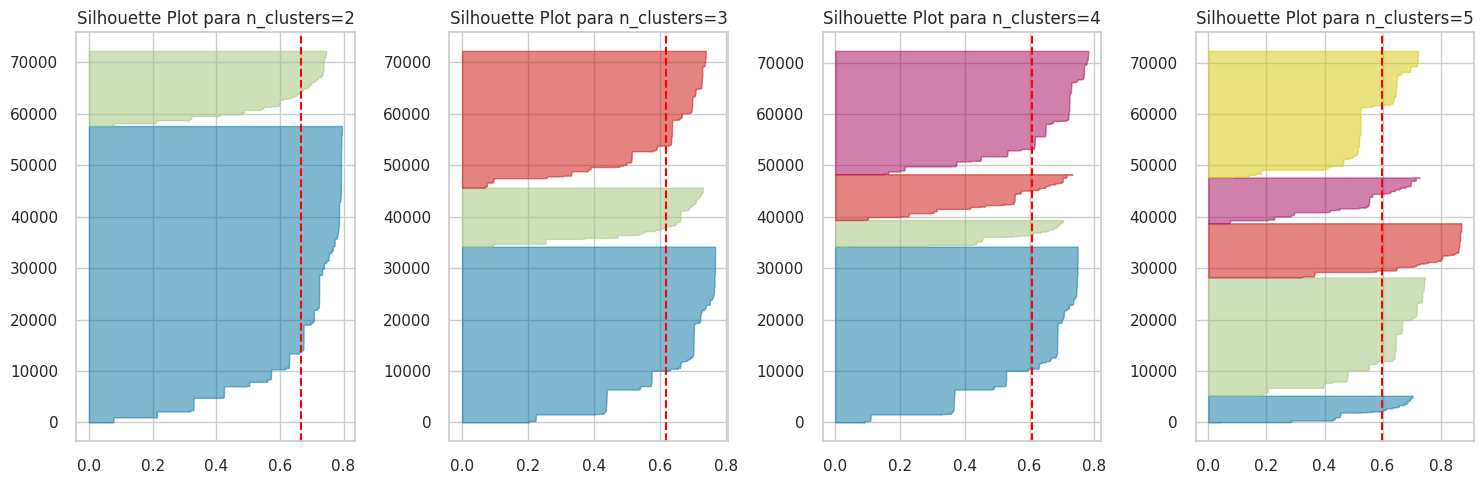

In [263]:
# Define the range of cluster numbers
cluster_range = [2, 3, 4, 5]

# Create subplots
fig, axes = plt.subplots(1, len(cluster_range), figsize=(15, 5))

# Iterate over each cluster number
for i, n_clusters in enumerate(cluster_range):
    model = KMeans(n_clusters=n_clusters, random_state=KMEANS_SEED)
    visualizer = SilhouetteVisualizer(model, colors='yellowbrick', ax=axes[i])
    visualizer.fit(ds_cluster_train)
    axes[i].set_title(f'Silhouette Plot para n_clusters={n_clusters}')

plt.tight_layout()
plt.show()

En estos graficos silhouette se aprecia que la clusterizacion con K=2 es muy desbalanceada, por lo que observamos que K=4 o K=5 podrian ser mejores candidatos.

In [264]:
balance_analisis_ds = ds_cluster_train.copy()

In [265]:
def print_clusters_info(clusters_ds, min_clusters, max_clusters):
    for i in range(min_clusters, max_clusters+1):
        groups = KMeans(n_clusters=i, random_state=KMEANS_SEED)
        groups.fit(clusters_ds)
        y_groups = groups.predict(clusters_ds)

        clusters_ds['Cluster'] = y_groups
        print(f"{i} Clusters:\n", clusters_ds["Cluster"].value_counts(), "\n")
        clusters_ds.drop(columns=['Cluster'], inplace=True)

In [266]:
print_clusters_info(balance_analisis_ds, 2, 5)

2 Clusters:
 Cluster
0    57624
1    14600
Name: count, dtype: int64 

3 Clusters:
 Cluster
0    34169
2    26594
1    11461
Name: count, dtype: int64 

4 Clusters:
 Cluster
0    34169
3    23980
2     8895
1     5180
Name: count, dtype: int64 

5 Clusters:
 Cluster
4    24618
1    22997
2    10534
3     8895
0     5180
Name: count, dtype: int64 



Luego de ver esta distribucion tenemos la siguiente tabla:

* k = 2, `score: 0.66, division: 57k/14k`
* k = 3, `score: 0.61, division: 34k/26k/11k`
* k = 4, `score: 0.60, division: 34k/23k/8k/5k`
* k = 5, `score: 0.59, division: 24k/22k/10k/8k/5k`

vemos que K=3 y K=4 son los mejores candidatos teniendo en cuenta su score y balance. Analizaremos ambos.

## Análisis de grupos

En esta seccion se realizara un analisis completo de los clusters obtenidos, para llegar a una conclusion de porque se formaron. En base a el punto anterior decidimos tomar K=4 que tiene un silhouette score de 0.60 y una distribucion de 34 mil / 23 mil / 8 mil / 5 mil.

In [267]:
cluster_analisis_ds = ds_cluster_train.copy()

four_groups = KMeans(n_clusters=4, random_state=KMEANS_SEED)
four_groups.fit(cluster_analisis_ds)
y_four_groups = four_groups.predict(cluster_analisis_ds)

cluster_analisis_ds['Cluster'] = y_four_groups

cluster_analisis_ds['Cluster'].value_counts()

Cluster
0    34169
3    23980
2     8895
1     5180
Name: count, dtype: int64

In [268]:
# Para algunas cosas querremos saber los datos sin minmax aplicado
ds_cluster_train_sin_mod = ds_train.copy()

### Por cercania geografica

Ahora pasamos a analizar si estos clusters se crearon teniendo en cuenta la ubicacion de las propiedades.

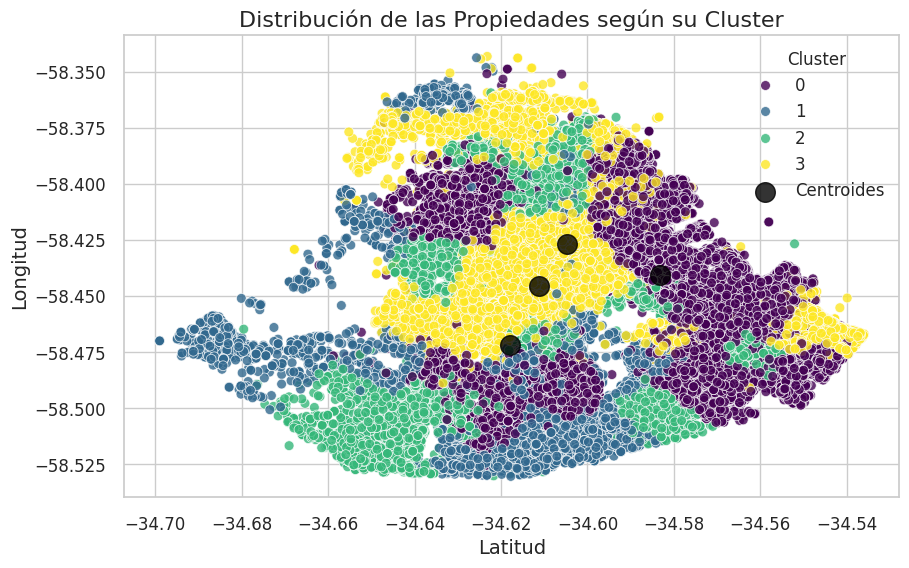

In [269]:
plt.figure(figsize=(10, 6))

# Mostrar propiedades
sns.scatterplot(data=cluster_analisis_ds, x='latitud', y='longitud', hue='Cluster', palette='viridis', s=50, alpha=0.8)

# Mostrar Centroides
centers = four_groups.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.8, label='Centroides')

plt.title('Distribución de las Propiedades según su Cluster', fontsize=16)
plt.xlabel('Latitud', fontsize=14)
plt.ylabel('Longitud', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Cluster', fontsize=12, title_fontsize=12)
plt.show()

Segun lo que se puede apreciar en este grafico, hay una clara separacion geografica entre el clusters pero no nos dice mucha informacion relevante a simple vista.

Ahondaremos mas en la separacion entre clusters por barrio, para ver si estos tuvieron peso en la creacion de dichos clusters.

### Por barrio

Cada barrio fue mapeado a un numero empezando en 0 antes de clusterizar (el orden es albitrario). Observamos la agrupacion por barrio traduciendo dichos numeros a los nombres correspondientes.

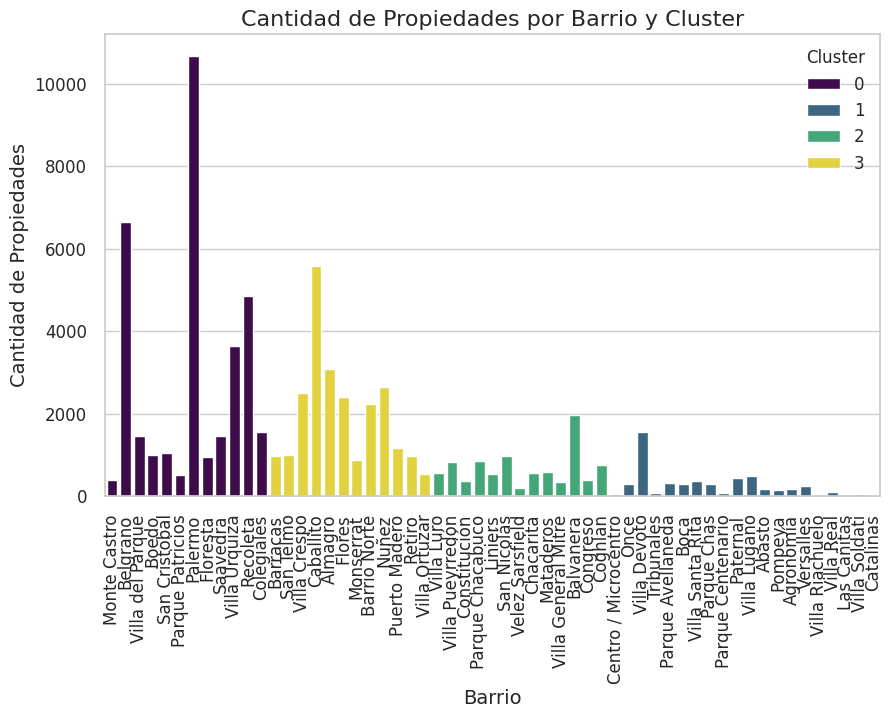

{0: 'Monte Castro', 1: 'Belgrano', 2: 'Villa del Parque', 3: 'Boedo', 4: 'San Cristobal', 5: 'Parque Patricios', 6: 'Palermo', 7: 'Floresta', 8: 'Saavedra', 9: 'Villa Urquiza', 10: 'Recoleta', 11: 'Colegiales', 12: 'Barracas', 13: 'San Telmo', 14: 'Villa Crespo', 15: 'Caballito', 16: 'Almagro', 17: 'Flores', 18: 'Monserrat', 19: 'Barrio Norte', 20: 'Nuñez', 21: 'Puerto Madero', 22: 'Retiro', 23: 'Villa Ortuzar', 24: 'Villa Luro', 25: 'Villa Pueyrredón', 26: 'Constitución', 27: 'Parque Chacabuco', 28: 'Liniers', 29: 'San Nicolás', 30: 'Velez Sarsfield', 31: 'Chacarita', 32: 'Mataderos', 33: 'Villa General Mitre', 34: 'Balvanera', 35: 'Congreso', 36: 'Coghlan', 37: 'Centro / Microcentro', 38: 'Once', 39: 'Villa Devoto', 40: 'Tribunales', 41: 'Parque Avellaneda', 42: 'Boca', 43: 'Villa Santa Rita', 44: 'Parque Chas', 45: 'Parque Centenario', 46: 'Paternal', 47: 'Villa Lugano', 48: 'Abasto', 49: 'Pompeya', 50: 'Agronomía', 51: 'Versalles', 52: 'Villa Riachuelo', 53: 'Villa Real', 54: 'Las 

In [270]:
plotting = cluster_analisis_ds.copy()

plotting['place_l3'] = plotting['place_l3'].map(place_l3_inv_dict)

plt.figure(figsize=(10, 6))
sns.countplot(data=plotting, x='place_l3', hue='Cluster', palette='viridis')
plt.title('Cantidad de Propiedades por Barrio y Cluster', fontsize=16)
plt.xlabel('Barrio', fontsize=14)
plt.ylabel('Cantidad de Propiedades', fontsize=14)
plt.xticks(fontsize=12)
plt.xticks(rotation=90)
plt.yticks(fontsize=12)
plt.legend(title='Cluster', fontsize=12, title_fontsize=12)
plt.show()

print(place_l3_inv_dict)

Ahora si observamos una muy clara clusterizacion por barrio, los clusters no se mezclan, es decir no hay 2 clusters compartiendo un barrio entre si. Como se puede observar el primer cluster tomo los primeros barrios, el segundo tomo los proximos y asi sucesivamente. Tambien se nota una diferencia entre las cantidades de propiedades y los clusters, parece que el ratio cantidad/barrio va disminuyendo a medida que nos movemos en el eje horizontal, sin embargo no se puede concluir que esto realmente es un factor que se tomo en cuenta en **kmeans** a menos que los barrios hayan tenido una especie de pre-orden por cantidad de propiedades en cada barrio.

### Por tipo de propiedad

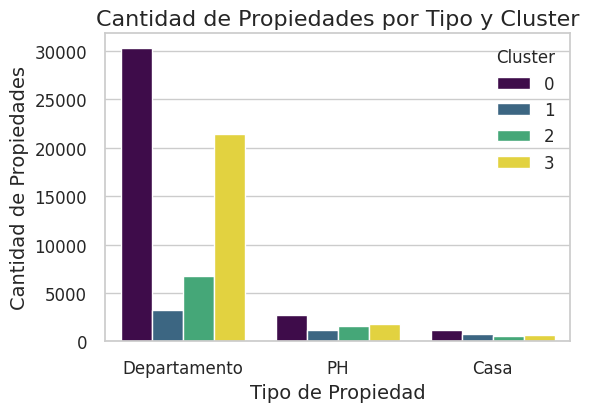

In [271]:
plotting = cluster_analisis_ds.copy()

plotting['property_type'] = ds_cluster_train_sin_mod['property_type']

plt.figure(figsize=(6, 4))
sns.countplot(data=plotting, x='property_type', hue='Cluster', palette='viridis')
plt.title('Cantidad de Propiedades por Tipo y Cluster', fontsize=16)
plt.xlabel('Tipo de Propiedad', fontsize=14)
plt.ylabel('Cantidad de Propiedades', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Cluster', fontsize=12, title_fontsize=12)
plt.show()

Observando el grafico vemos que si una propiedad es un departamento hay una mas alta probabilidad que esa propiedad pertenezca a los clusters 0 o 3 (esto se puede deber a que hay mas propiedades en dichos clusters), mientras que si una propiedad es de tipo ph o casa los clusters estan mas mezclados.

### Por precio

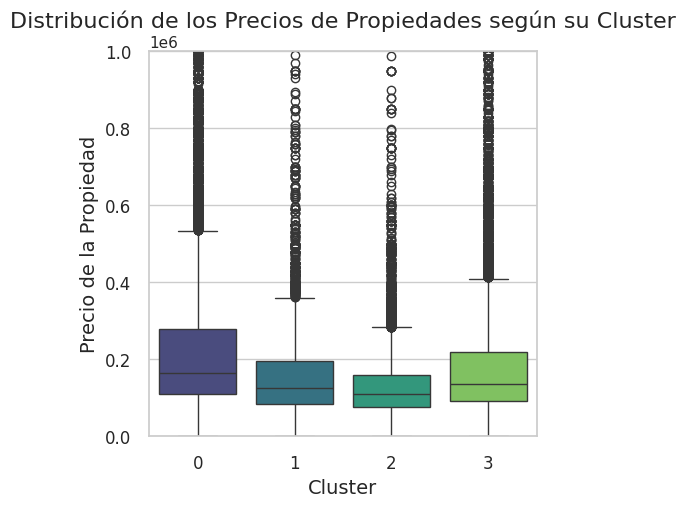

In [272]:
plt.figure(figsize=(5, 5))

ds_cluster_train_sin_mod["Cluster"] = cluster_analisis_ds["Cluster"]

sns.boxplot(data=ds_cluster_train_sin_mod, x='Cluster', y='property_price', palette='viridis')

plt.ylim(0, 1000000)

plt.title('Distribución de los Precios de Propiedades según su Cluster', fontsize=16)
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Precio de la Propiedad', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Este boxplot demuestra que el cluster cuya demografica tiene menor precio es el 2, luego le sigue el 1 y el 3, y finalmente el cluster con precios mas elevados es el 0.

Puede ser que el precio se haya tenido en cuenta a la hora de clusterizar pero no en gran medida, ya que hay muchas propiedades cuyo precio puede caer en cualquiera de los 4 clusters.

### Por cantidad de dormitorios y ambientes

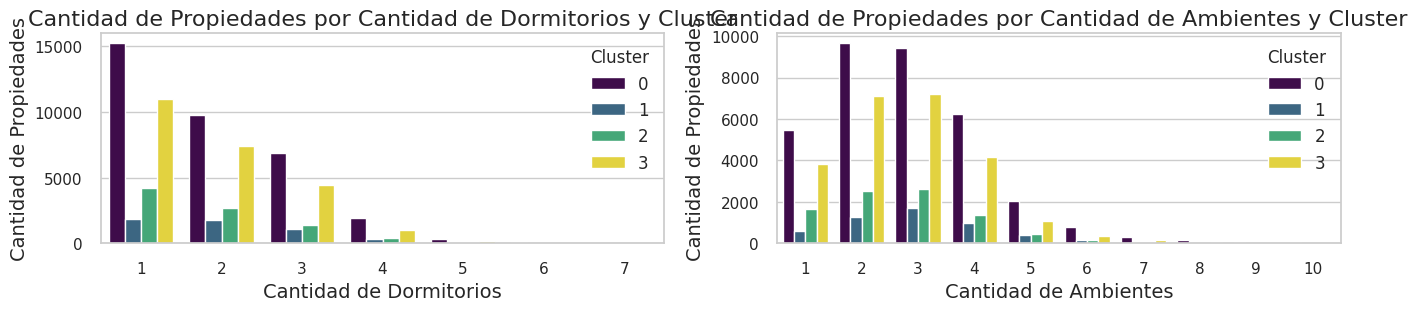

In [273]:
# plot all property_bedrooms by cluster
plotting = cluster_analisis_ds.copy()
plotting['property_bedrooms'] = ds_cluster_train_sin_mod['property_bedrooms']
plotting['property_rooms'] = ds_cluster_train_sin_mod['property_rooms']

plt.figure(figsize=(16, 6))

plt.subplot(2, 2, 1)
sns.countplot(data=plotting, x='property_bedrooms', hue='Cluster', palette='viridis')
plt.title('Cantidad de Propiedades por Cantidad de Dormitorios y Cluster', fontsize=16)
plt.xlabel('Cantidad de Dormitorios', fontsize=14)
plt.ylabel('Cantidad de Propiedades', fontsize=14)
plt.legend(title='Cluster', fontsize=12, title_fontsize=12)

plt.subplot(2, 2, 2)
sns.countplot(data=plotting, x='property_rooms', hue='Cluster', palette='viridis')
plt.title('Cantidad de Propiedades por Cantidad de Ambientes y Cluster', fontsize=16)
plt.xlabel('Cantidad de Ambientes', fontsize=14)
plt.ylabel('Cantidad de Propiedades', fontsize=14)
plt.legend(title='Cluster', fontsize=12, title_fontsize=12)
plt.show()

plt.show()


Aca podemos observar que las habitaciones y ambientes no tuvieron impacto en la creacion de los clusters, esto se ve ya que todos los clusters contienen todas las cantidades de dichas variables, solo que en diferentes medidas.

### Por superficie

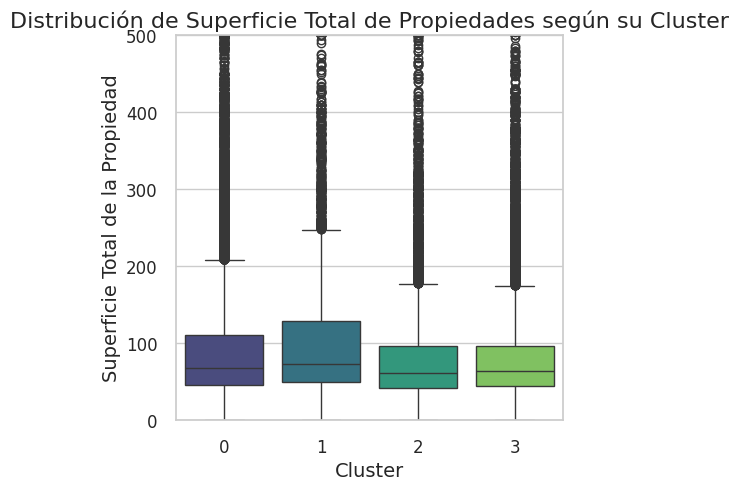

In [274]:
# plot all property_surface_total by cluster

plotting = cluster_analisis_ds.copy()

plotting['property_surface_total'] = ds_cluster_train_sin_mod['property_surface_total']

plt.figure(figsize=(5, 5))
sns.boxplot(data=plotting, x='Cluster', y='property_surface_total', palette='viridis')
plt.title('Distribución de Superficie Total de Propiedades según su Cluster', fontsize=16)
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Superficie Total de la Propiedad', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 500)
plt.show()

Como se pude ver en este boxplot, los clusters tampoco parecen haber sido creados en funcion de la superficie de las propiedades, ya que todos tienen muy similar distribucion.

Adicionalmente a este analisis de variables, tambien se hizo un pairplot para ver a grandes razgos todas las variables y su correlacion con la clusterizacion, pero este no proporcionaba informacion adicional a lo visto hasta ahora, por ende no esta incluido en este notebook.

**En conclusion, la agrupacion con k=4 se hizo por *barrio* principalmente, y hay indicios de que se pudo haber tambien considerado el tipo y precio de propiedad.**

## Clusters en el mapa de CABA <font color='#fa5050'>(Completar según termine análisis de cluster)</font>

In [275]:
cluster_analisis_ds.head()

latitud   longitud  place_l3  property_rooms  property_bedrooms  \
0 -34.621390 -58.506366         0        0.222222           0.166667   
1 -34.563005 -58.453674         1        0.222222           0.166667   
2 -34.612349 -58.491906         2        0.222222           0.166667   
3 -34.620806 -58.397336         3        0.222222           0.166667   
4 -34.558229 -58.446708         1        0.222222           0.166667   

   property_surface_total  property_surface_covered  property_price  \
0                  0.0204                  0.043180        0.005234   
1                  0.0316                  0.064769        0.014014   
2                  0.0440                  0.078508        0.011636   
3                  0.0388                  0.065751        0.006308   
4                  0.0356                  0.087341        0.014019   

   property_type_Casa  property_type_Departamento  property_type_PH  Cluster  
0               False                        True             False        0  
1               False                        True             False        0  
2               False                        True             False        0  
3               False                       False              True        0  
4               False                        True             False        0

In [276]:
ds_barrios.head()

WKT            BARRIO  \
0  MULTIPOLYGON (((-58.4528200492791 -34.59598865...         CHACARITA   
1  MULTIPOLYGON (((-58.4655768128541 -34.59655770...          PATERNAL   
2  MULTIPOLYGON (((-58.4237529813037 -34.59782733...      VILLA CRESPO   
3  MULTIPOLYGON (((-58.4946097568899 -34.61486523...  VILLA DEL PARQUE   
4  MULTIPOLYGON (((-58.4128700313088 -34.61411625...           ALMAGRO   

   COMUNA    PERIMETRO          AREA  OBJETO  
0    15.0  7724.852955  3.115707e+06  BARRIO  
1    15.0  7087.513295  2.229829e+06  BARRIO  
2    15.0  8131.857075  3.615978e+06  BARRIO  
3    11.0  7705.389797  3.399596e+06  BARRIO  
4     5.0  8537.901368  4.050752e+06  BARRIO

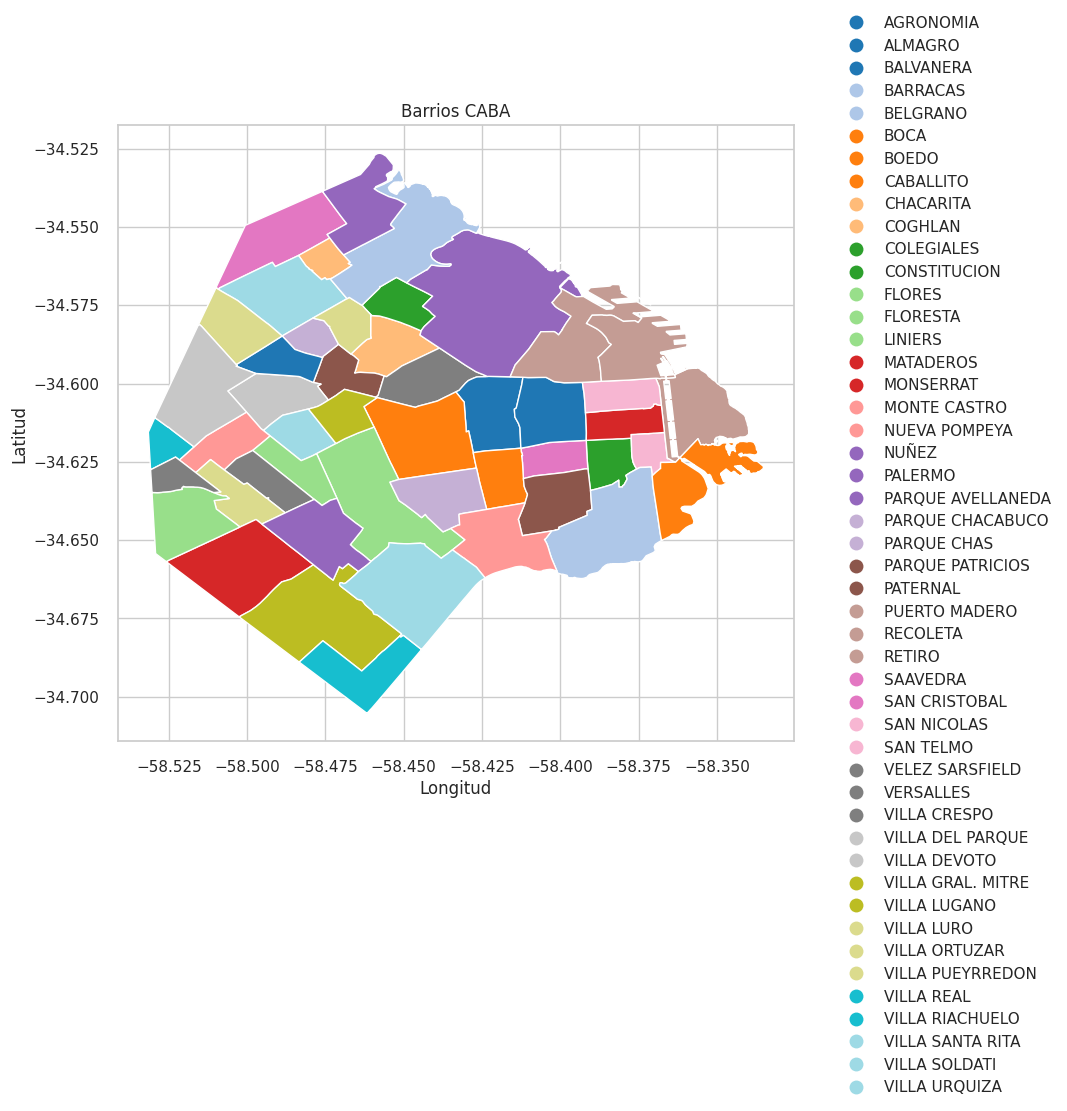

In [277]:
# Convertir la columna WKT a geometrías
ds_barrios['geometry'] = gpd.GeoSeries.from_wkt(ds_barrios['WKT'])

# Crear un DataFrame GeoPandas con la columna WKT convertida
gdf_barrios = gpd.GeoDataFrame(ds_barrios, geometry='geometry')

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(10, 8))

# Graficar los barrios con diferentes colores según el nombre del barrio
gdf_barrios.plot(ax=ax, column='BARRIO', legend=True, cmap='tab20')

# Configurar la leyenda
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.4, 1.2))

# Configurar título y etiquetas de los ejes
ax.set(title='Barrios CABA', xlabel='Longitud', ylabel='Latitud')

plt.show()


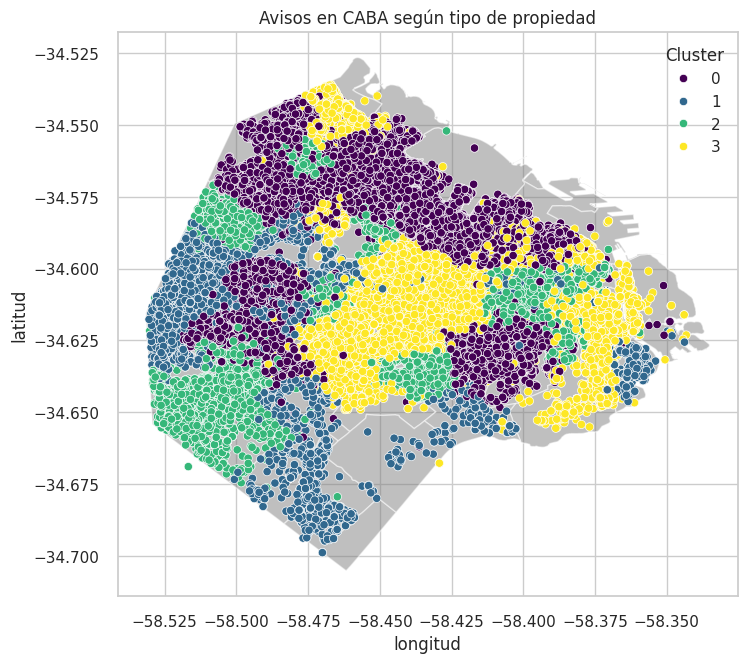

In [278]:
fig, ax = plt.subplots(figsize=(8, 8))

# Graficar los límites de los barrios de CABA
gdf_barrios.plot(ax=ax, color='grey', alpha = 0.5)

# Graficar los puntos coloreados por cluster
sns.scatterplot(ax=ax, data=cluster_analisis_ds, x='longitud', y='latitud', hue='Cluster', palette='viridis')

# Configurar título y etiquetas de los ejes
ax.set(title='Avisos en CABA según tipo de propiedad')
plt.show()

In [279]:
def visualizar_por_cluster(cantidad):
  cluster = cluster_analisis_ds[cluster_analisis_ds['Cluster'] == cantidad]

  # Crear la figura y los ejes
  fig, ax = plt.subplots(figsize=(8, 8))

  # Graficar los límites de los barrios de CABA
  gdf_barrios.plot(ax=ax, color='grey', alpha=0.5)

  # Graficar solo los puntos del cluster 0 coloreados por cluster
  sns.scatterplot(ax=ax, data=cluster, x='longitud', y='latitud', color='red',alpha=0.5)

  titulo = 'Avisos en CABA para el Cluster {}'.format(cantidad)

  # Configurar título y etiquetas de los ejes
  ax.set(title=titulo)
  plt.show()
  return
# Filtrar el DataFrame cluster_analisis_ds para incluir solo el cluster 0


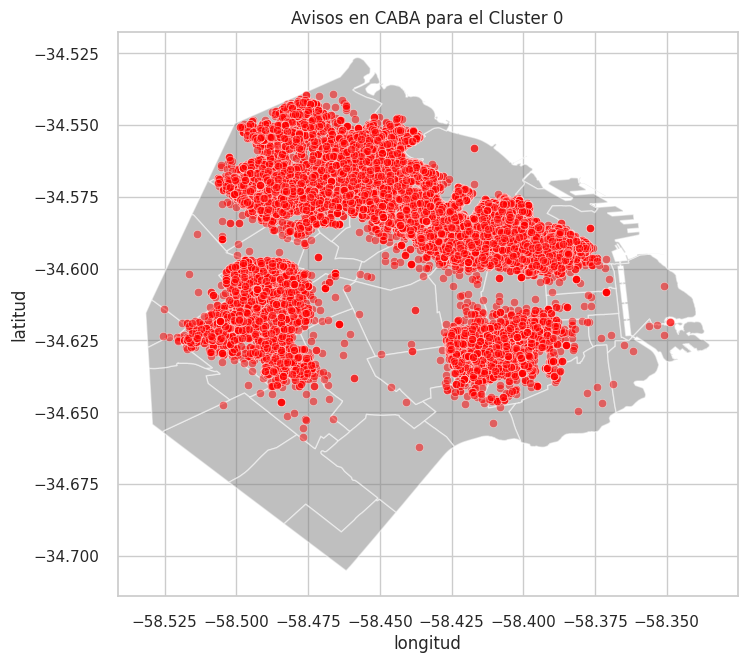

In [280]:
visualizar_por_cluster(0)

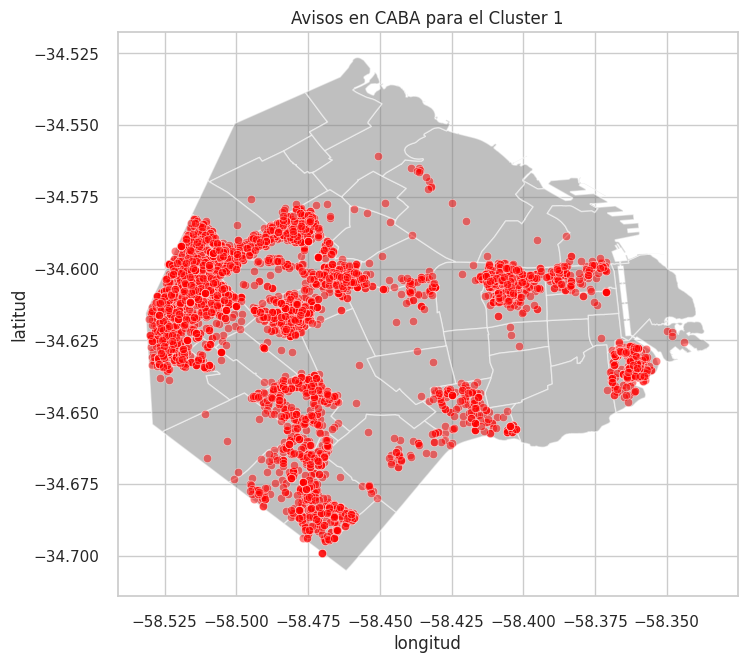

In [281]:
visualizar_por_cluster(1)

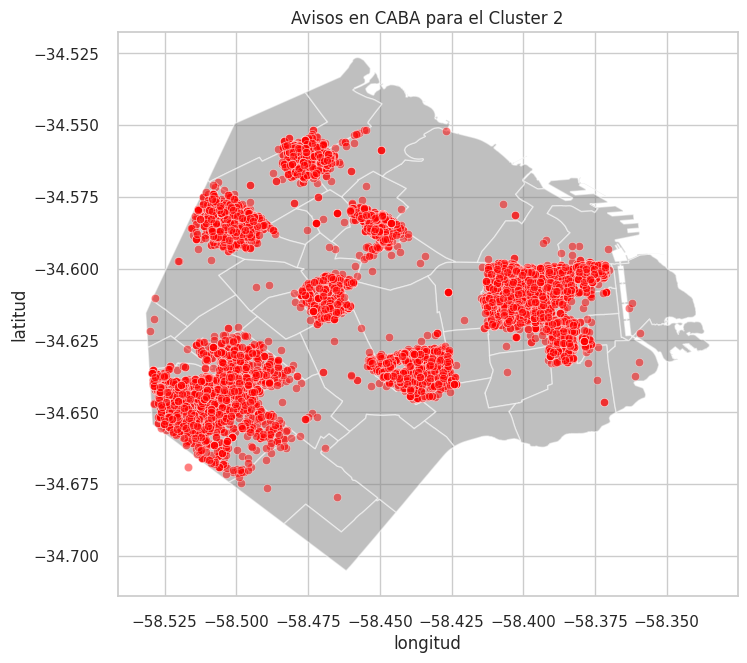

In [282]:
visualizar_por_cluster(2)

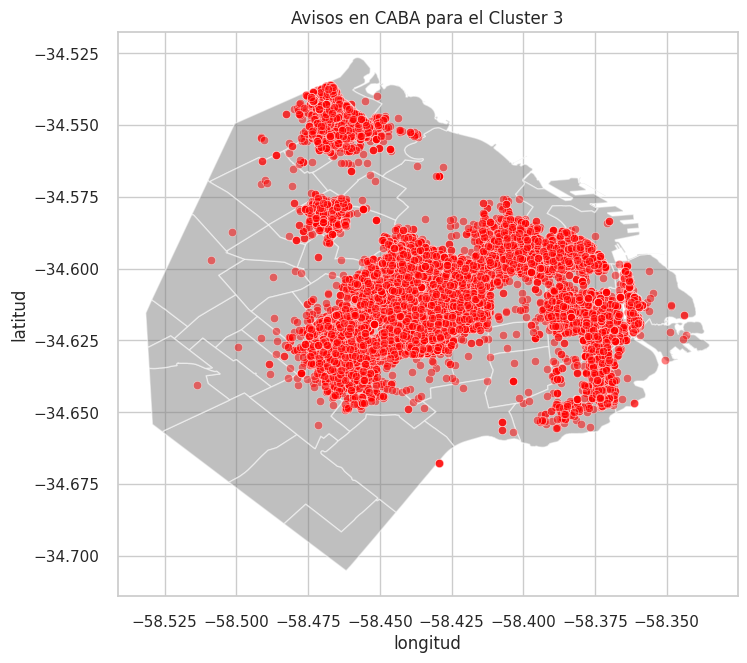

In [283]:
visualizar_por_cluster(3)

## Análisis con tres grupos</font>

En esta seccion se hara un analisis similar al anteriormente hecho pero esta vez clusterizando con un **K=3**.

In [284]:
# Copiamos el ds para poder modificarlo sin repercusiones
ds_cluster_analisis_3 = ds_cluster_train.copy()

In [285]:
# Creamos una instancia del modelo K-Means con 3 clusters
num_clusters = 3
three_groups = KMeans(n_clusters=num_clusters, random_state=KMEANS_SEED)

# Ajustamos el modelo a los datos
three_groups.fit(ds_cluster_analisis_3)
y_three_groups = three_groups.predict(ds_cluster_analisis_3)

# Agregamos las etiquetas de los clusters al dataframe original
ds_cluster_analisis_3['cluster'] = y_three_groups

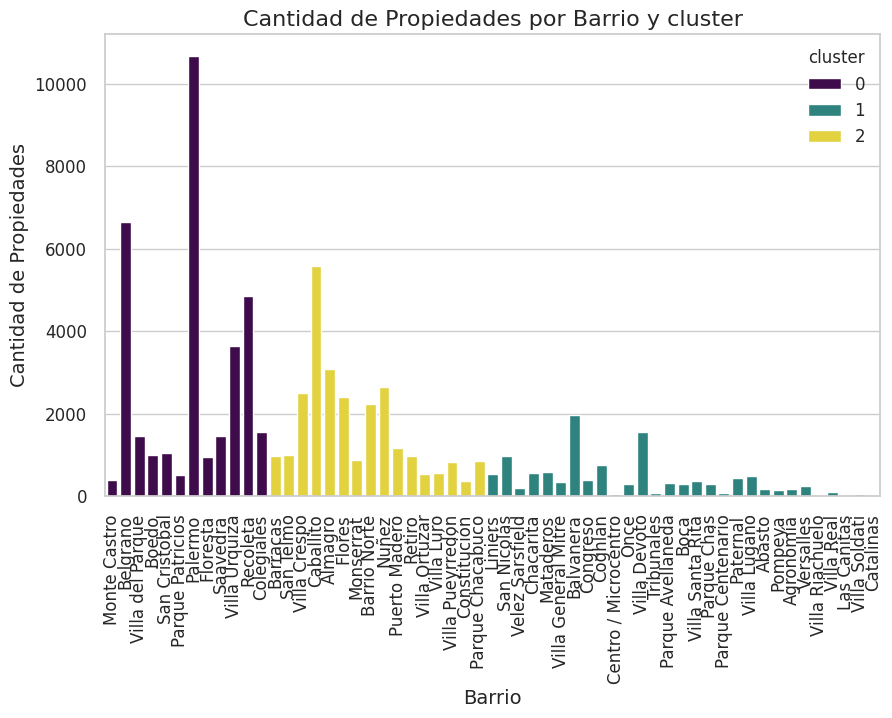

In [286]:
plotting = ds_cluster_analisis_3.copy()

plotting['place_l3'] = plotting['place_l3'].map(place_l3_inv_dict)

plt.figure(figsize=(10, 6))
sns.countplot(data=plotting, x='place_l3', hue='cluster', palette='viridis')
plt.title('Cantidad de Propiedades por Barrio y cluster', fontsize=16)
plt.xlabel('Barrio', fontsize=14)
plt.ylabel('Cantidad de Propiedades', fontsize=14)
plt.xticks(fontsize=12)
plt.xticks(rotation=90)
plt.yticks(fontsize=12)
plt.legend(title='cluster', fontsize=12, title_fontsize=12)
plt.show()

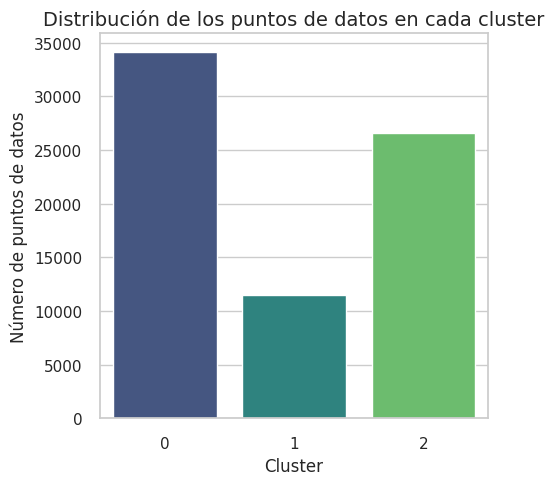

In [287]:
# Calculamos la cantidad de puntos de datos en cada cluster
cluster_counts = ds_cluster_analisis_3['cluster'].value_counts()

# Visualizamos la distribución de los clusters
plt.figure(figsize=(5, 5))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Número de puntos de datos', fontsize=12)
plt.title('Distribución de los puntos de datos en cada cluster', fontsize=14)
plt.xticks(rotation=0)
plt.show()


<Figure size 1200x800 with 0 Axes>

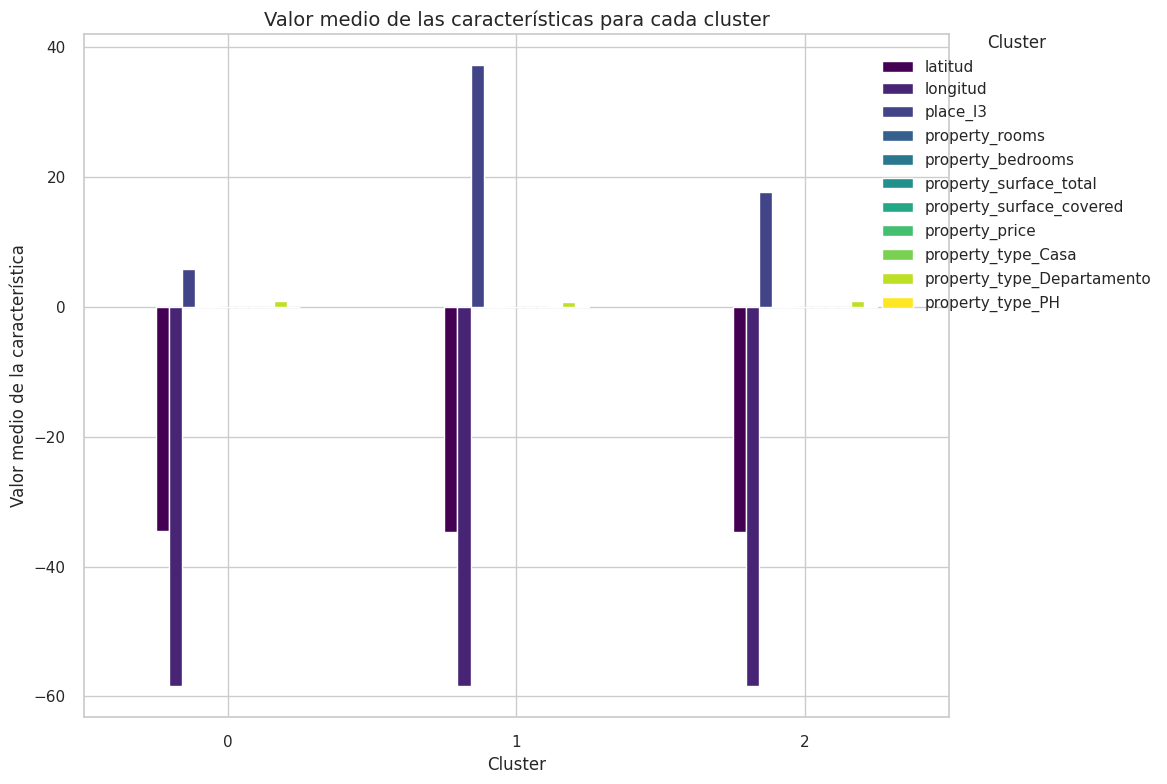

In [288]:
# Calculamos las medias de las características para cada cluster
cluster_means = ds_cluster_analisis_3.groupby('cluster').mean()

# Visualizamos las medias de las características para cada cluster
plt.figure(figsize=(12, 8))
cluster_means.plot(kind='bar', figsize=(12, 8), cmap='viridis')
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Valor medio de la característica', fontsize=12)
plt.title('Valor medio de las características para cada cluster', fontsize=14)
plt.xticks(rotation=0)
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1.02), title="Cluster")
plt.tight_layout()
plt.show()


El agrupamiento se basa en K-MEANS, calculo las medias de las características para cada cluster después de realizar el agrupamiento con el algoritmo K-Means. El propósito de la visualización es comparar las medias de las características entre los diferentes clusters. Esto puede ayudar a identificar patrones o diferencias significativas en las características dentro de cada cluster, lo que puede proporcionar información valiosa sobre la estructura y la interpretación de los grupos identificados por el algoritmo de agrupamiento.

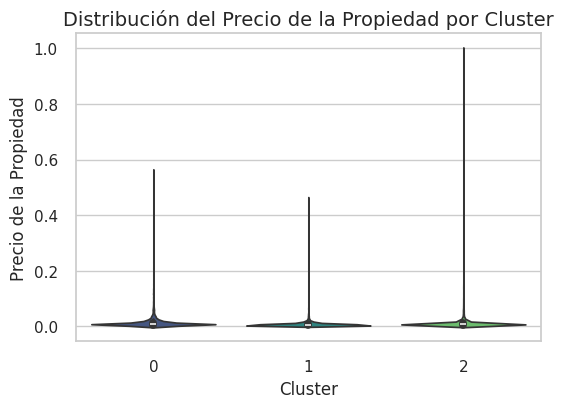

In [289]:
# Visualizamos la distribución de una característica específica por cluster
plt.figure(figsize=(6, 4))
sns.violinplot(data=ds_cluster_analisis_3, x='cluster', y='property_price', palette='viridis')
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Precio de la Propiedad', fontsize=12)
plt.title('Distribución del Precio de la Propiedad por Cluster', fontsize=14)
plt.show()


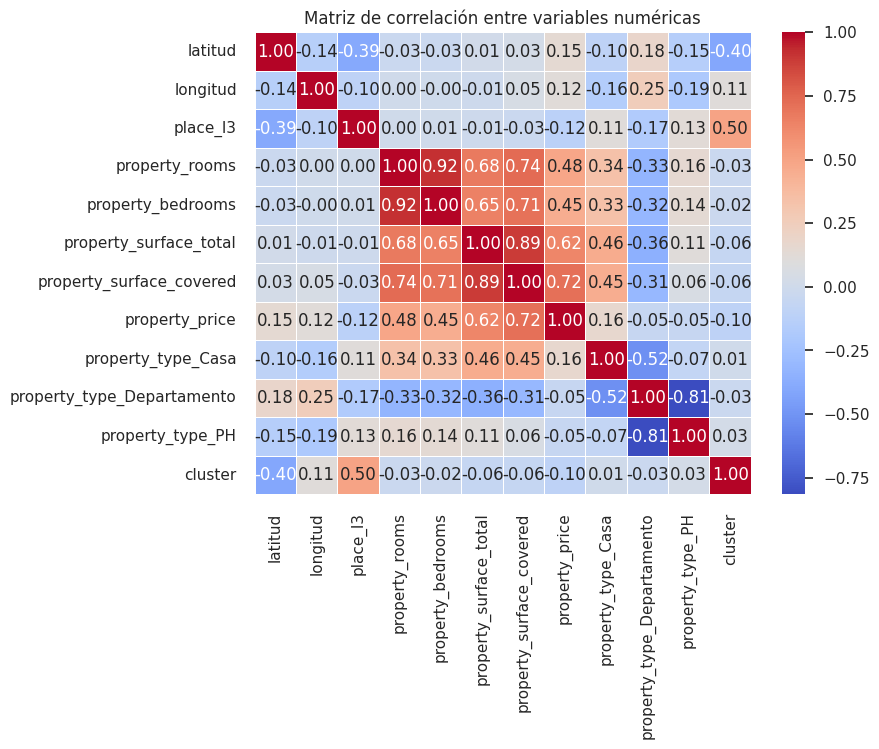

In [290]:
# Calculamos correlaciones entre variables numéricas
correlation_matrix = ds_cluster_analisis_3.corr()

# Visualizamos la matriz de correlación
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriz de correlación entre variables numéricas')
plt.show()

El propósito de incluir la matriz de correlaciones es proporcionar información adicional sobre cómo están relacionadas las variables numéricas entre sí. La información es útil para comprender mejor las estructuras de los datos y los patrones subyacentes que pueden influir en la formación de los clusters identificados por el algoritmo de K-Means. Por ejemplo, si hay variables altamente correlacionadas, esto puede indicar que comparten información similar y pueden influir en la forma en que se agrupan las observaciones en clusters. Cada celda en el heapmap representa el coeficiente de correlación entre dos variables (un valor cercano a 1 indica una correlación positiva fuerte, lo que significa que las variables tienden a aumentar juntas)

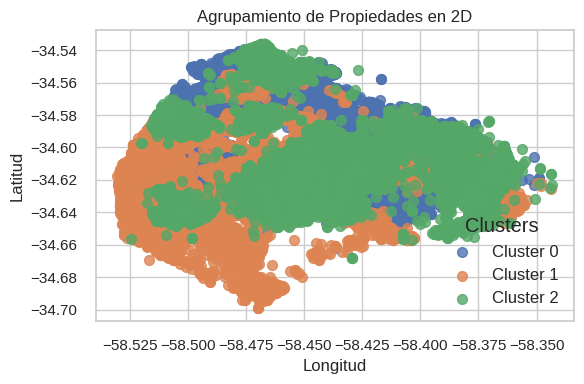

In [291]:
# Seleccionamos las columnas relevantes para la visualización
columns_for_visualization = ['latitud', 'longitud']

# Creamos el gráfico de dispersión
plt.figure(figsize=(6, 4))
for cluster in range(num_clusters):
    cluster_data = ds_cluster_analisis_3[ds_cluster_analisis_3['cluster'] == cluster]
    plt.scatter(cluster_data['longitud'], cluster_data['latitud'], label=f'Cluster {cluster}', alpha=0.8, s=50)

# Agregamos leyenda y etiquetas
plt.title('Agrupamiento de Propiedades en 2D')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.legend(title='Clusters', fontsize='medium', title_fontsize='large')
plt.grid(True)

# Mejoramos la estética
plt.style.use('seaborn-dark')
plt.tight_layout()

# Mostramos el gráfico
plt.show()

In [292]:
# Calculamos los valores promedio de cada característica dentro de cada grupo
group_means = ds_cluster_analisis_3.groupby('cluster').mean()

# Mostramos los valores promedio de cada característica para cada grupo
print(group_means)

           latitud   longitud   place_l3  property_rooms  property_bedrooms  \
cluster                                                                       
0       -34.583228 -58.440593   5.853669        0.205573           0.151385   
1       -34.612624 -58.452923  37.315505        0.204025           0.152677   
2       -34.605948 -58.430480  17.665564        0.195382           0.142307   

         property_surface_total  property_surface_covered  property_price  \
cluster                                                                     
0                      0.038797                  0.081140        0.012384   
1                      0.037342                  0.073977        0.006863   
2                      0.034435                  0.072040        0.009396   

         property_type_Casa  property_type_Departamento  property_type_PH  
cluster                                                                    
0                  0.034037                    0.886622          0

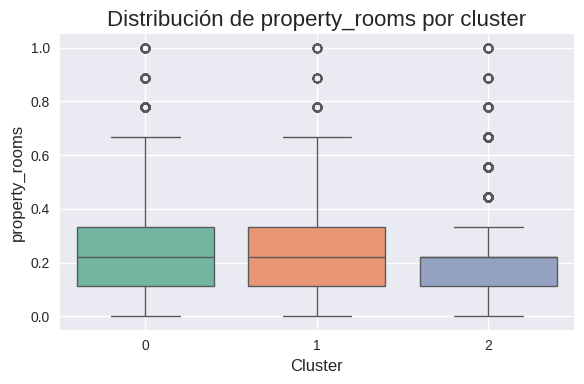

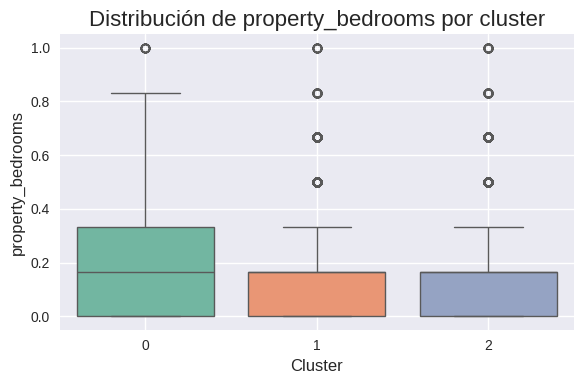

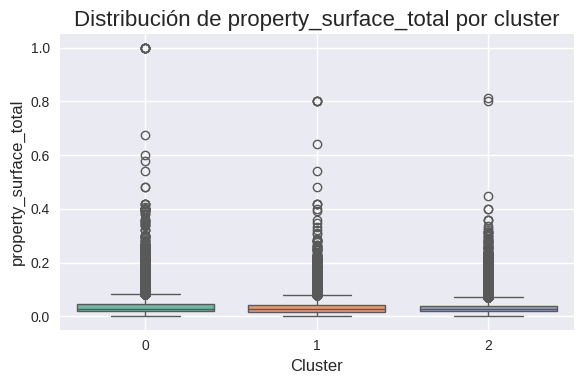

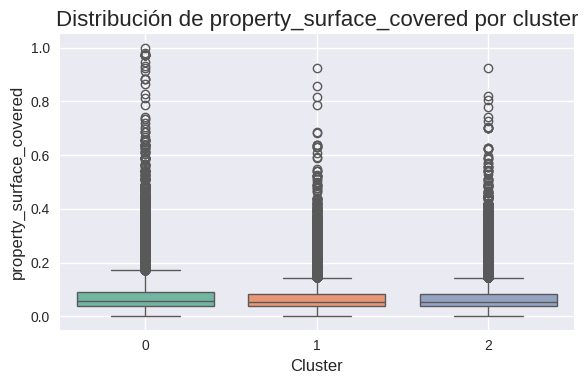

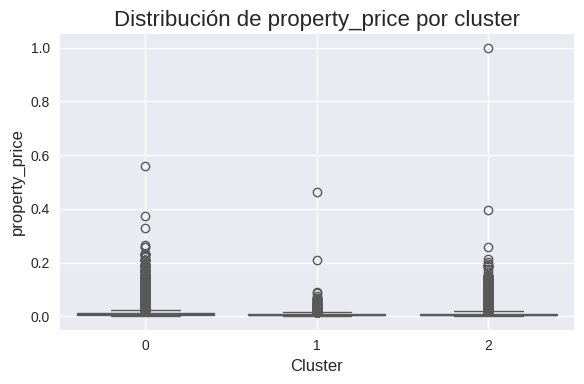

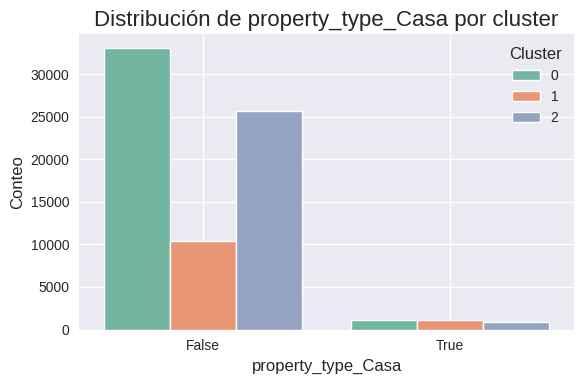

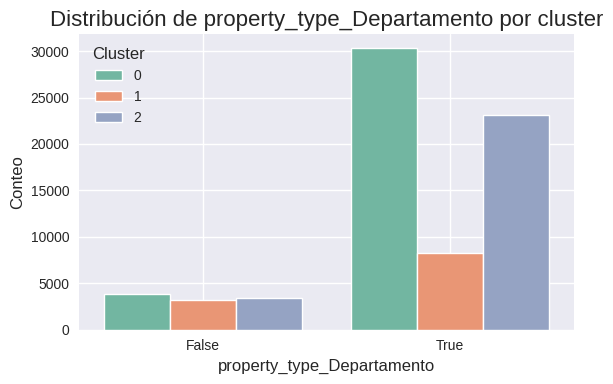

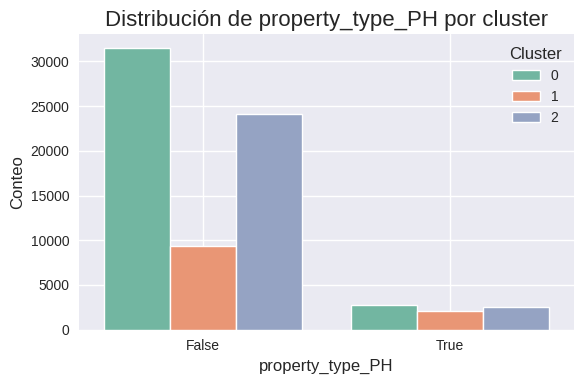

In [293]:
numerical_columns = ['property_rooms', 'property_bedrooms',
                     'property_surface_total', 'property_surface_covered', 'property_price']
categorical_columns = ['property_type_Casa', 'property_type_Departamento', 'property_type_PH']


# Gráficos de distribución para variables numéricas por cluster
for num_col in numerical_columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='cluster', y=num_col, data=ds_cluster_analisis_3, palette='Set2')
    plt.title(f'Distribución de {num_col} por cluster', fontsize=16)
    plt.xlabel('Cluster', fontsize=12)
    plt.ylabel(f'{num_col}', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Gráficos de conteo para variables categóricas por cluster
for cat_col in categorical_columns:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=cat_col, hue='cluster', data=ds_cluster_analisis_3, palette='Set2')
    plt.title(f'Distribución de {cat_col} por cluster', fontsize=16)
    plt.xlabel(f'{cat_col}', fontsize=12)
    plt.ylabel('Conteo', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend(title='Cluster', fontsize=10, title_fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Análisis de Variables Numéricas:

Observamos que el grupo 0 tiende a tener propiedades con mayor superficie total y superficie cubierta en comparación con los otros grupos. El grupo 1 parece tener propiedades con menos habitaciones y dormitorios en promedio, pero con precios más bajos. Por otro lado, el grupo 2 presenta un rango más amplio de precios, con algunas propiedades de mayor valor y otras más económicas.

Análisis de Variables Categóricas:

En cuanto al tipo de propiedad, el grupo 0 está compuesto principalmente por casas, mientras que los grupos 1 y 2 tienen una mayor proporción de departamentos y PH. En términos de distribución por barrio, observamos que cada grupo tiene una distribución diferente, lo que indica posibles preferencias de ubicación para diferentes tipos de propiedades.

# Guardado del dataset clusterizado

* K=4
* Con pre-procesamiento (min-max, etc)

In [296]:
# Revertir el encodeo de barrios
cluster_analisis_ds['place_l3'] = cluster_analisis_ds['place_l3'].map(place_l3_inv_dict)

if using_drive:
  cluster_analisis_ds.to_csv(drive_path + "/Dataset/ds_cluster_train.csv", index=False)
else:
  cluster_analisis_ds.to_csv("./dataset/ds_cluster_train.csv", index=False)